# **Project: Continuum Suppression**


Group Members:

1. Rajesh (MS20062)
2. Govind Sharma (MS20053)
3. Aniket Kumar (MS20189)
4. Palak Meena	(MS21005)

Data used can be accessed here: https://drive.google.com/file/d/1z4XnTmt3DPDITjZ-0P5blMmWLeNQF9YP/view?usp=sharing

Github repository: https://github.com/rajeshpotlia1/Continuum_Suppression

## Using CNN

In [ ]:
# last column = 61
#starting column = 2

#### Without PCA

In [1]:
import tensorflow as tf
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import plot_tree
!pip install graphviz
import graphviz

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access files in Google Drive
file_path = '/content/drive/MyDrive/data_hep.csv'

Mounted at /content/drive


In [3]:
import pandas as pd

# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [4]:
# Define a function to apply to each element in the column
def update_values(value):
    if value in [0, 1]:
        return 0
    else:
        return 1

# Apply the function to the specified column
column_index = 60
df.iloc[:, column_index] = df.iloc[:, column_index].apply(update_values)


In [5]:
counts = df.iloc[:, 60].value_counts()

# Display the counts
print("Count of 0s and 1s in the 61st column:")
print(counts)

Count of 0s and 1s in the 61st column:
0    35765
1    34841
Name: type, dtype: int64


In [6]:
# Here 0 represents signal and 1 represents noise or background.

In [7]:
# Shuffle all rows
shuffled_df = df.sample(frac=1).reset_index(drop=True)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Extract features (X) and labels (y) for the entire dataset
X = df.iloc[:, 1:60]  # Features from columns 1 to 59, excluding the first column
y = df.iloc[:, 60]    # Labels from the 61st column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60606, 59)
y_train shape: (60606,)
X_test shape: (10000, 59)
y_test shape: (10000,)


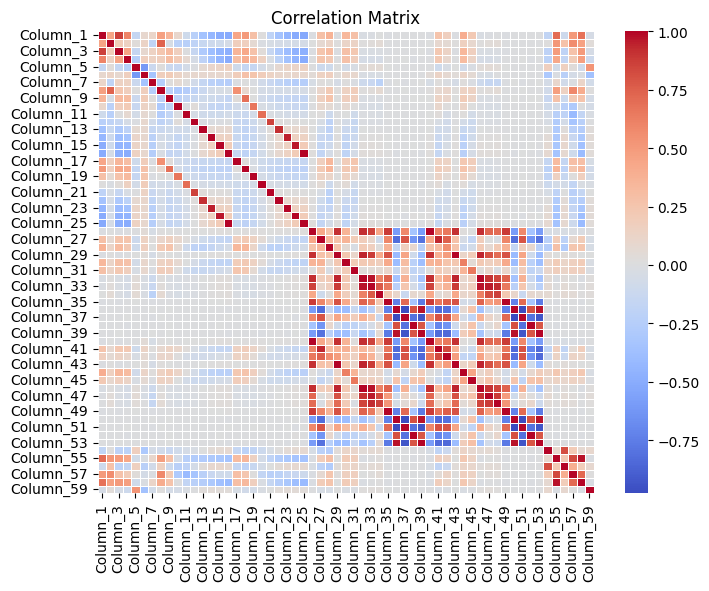

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate the correlation matrix
correlation_matrix = X.corr()
X.columns = [f'Column_{i}' for i in range(1, len(X.columns) + 1)]
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Create the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(59,)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    #tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    #tf.keras.layers.Dense(units=2, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3882 - accuracy: 0.8279 - val_loss: 0.3481 - val_accuracy: 0.8514
Epoch 2/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3451 - accuracy: 0.8510 - val_loss: 0.3306 - val_accuracy: 0.8581
Epoch 3/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3286 - accuracy: 0.8602 - val_loss: 0.3369 - val_accuracy: 0.8647
Epoch 4/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3177 - accuracy: 0.8654 - val_loss: 0.3125 - val_accuracy: 0.8675
Epoch 5/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3097 - accuracy: 0.8679 - val_loss: 0.3076 - val_accuracy: 0.8701
Epoch 6/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3036 - accuracy: 0.8707 - val_loss: 0.3032 - val_accuracy: 0.8711
Epoch 7/30
947/947 [==============================] - 2s 2ms/step - loss: 0.2984 - accuracy: 0.8725 - val_loss: 0.3020 - val_accuracy: 0.8761
Epoch 

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

y_pred_binary = np.array(y_pred_binary)


# Calculate the true positives, false positives, true negatives, and false negatives

true_positives = np.sum((y_pred_binary == 0) & (y_test == 0))
false_positives = np.sum((y_pred_binary == 1) & (y_test == 0))
true_negatives = np.sum((y_pred_binary == 1) & (y_test == 1))
false_negatives = np.sum((y_pred_binary == 0) & (y_test == 1))

# Create the table
table = [
    ["True Positives", true_positives],
    ["False Positives", false_positives],
    ["True Negatives", true_negatives],
    ["False Negatives", false_negatives]
]

# Calculate the maximum width of the first column
max_width = max(len(row[0]) for row in table)

# Print the table
print("Confusion Matrix:")
print("-----------------")
for row in table:
    print(f"{row[0]:<{max_width}} | {row[1]}")

print("-----------------")
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("-----------------")

313/313 [==============================] - 0s 949us/step
Accuracy: 0.8799
Confusion Matrix:
-----------------
True Positives  | 4659
False Positives | 454
True Negatives  | 4140
False Negatives | 747
-----------------
Accuracy: 0.8799
Precision: 0.9012
Recall: 0.8471
F1-Score: 0.8733
-----------------


#### With PCA

In [19]:
# removing the first column

shuffled_df.drop(shuffled_df.columns[0], axis=1, inplace=True)


# Performing PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_df = shuffled_df.iloc[:, :-1]
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_df)

# Specify the number of components you want to keep
n_components = 39  # Choose an appropriate number

# Create a PCA instance and fit it to your data
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

# Create a DataFrame with named columns
naming = [f'Feature {i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(data_pca, columns=naming)

pca_df['type'] = shuffled_df.iloc[:, -1]

Explained Variance Ratios: [0.23877695 0.13122607 0.11118835 0.06120968 0.04408818 0.03674613
 0.03351213 0.03101121 0.03035233 0.02924319 0.02879893 0.0268556
 0.02595215 0.02257745 0.02081227 0.01765659 0.01437694 0.01126342
 0.01008261 0.00884122 0.00861906 0.00727128 0.00654713 0.00544161
 0.00493992 0.00486653 0.00416373 0.00386175 0.00282193 0.00233674
 0.00224349 0.00200268 0.00160306 0.00137469 0.00123524 0.00103348
 0.00100682 0.00082243 0.00069414]


In [20]:
# Extract features (X) and labels (y) for the entire dataset
X_pca = pca_df.iloc[:, 0:n_components]  # Features from columns 0 to n_components
y_pca = pca_df.iloc[:, n_components]    # Labels from the (n_components+1)th column

# Split the data into training and test sets
pcaX_train, pcaX_test, pcaY_train, pcaY_test = train_test_split(X_pca, y_pca, test_size=10000, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", pcaX_train.shape)
print("y_train shape:", pcaY_train.shape)
print("X_test shape:", pcaX_test.shape)
print("y_test shape:", pcaY_test.shape)

X_train shape: (60606, 39)
y_train shape: (60606,)
X_test shape: (10000, 39)
y_test shape: (10000,)


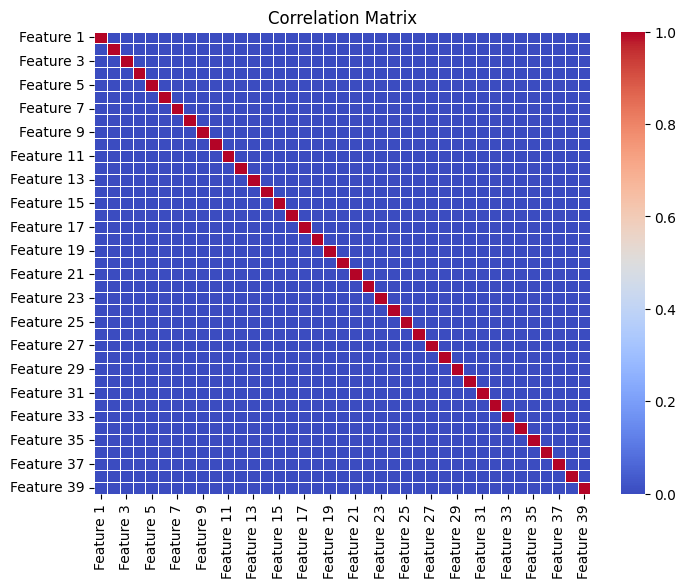

In [21]:
# Calculate the correlation matrix
correlation_matrix = X_pca.corr()
X_pca.columns = [f'Column_{i}' for i in range(1, len(X_pca.columns) + 1)]
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Create the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_components,)),
    tf.keras.layers.Dense(units=128, activation='relu'),
    #tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    #tf.keras.layers.Dense(units=2, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(pcaX_train, pcaY_train, epochs=30, batch_size=64, validation_data=(pcaX_test, pcaY_test))

Epoch 1/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3696 - accuracy: 0.8379 - val_loss: 0.3482 - val_accuracy: 0.8522
Epoch 2/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3372 - accuracy: 0.8549 - val_loss: 0.3398 - val_accuracy: 0.8544
Epoch 3/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3274 - accuracy: 0.8577 - val_loss: 0.3383 - val_accuracy: 0.8547
Epoch 4/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3206 - accuracy: 0.8623 - val_loss: 0.3302 - val_accuracy: 0.8582
Epoch 5/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3133 - accuracy: 0.8653 - val_loss: 0.3281 - val_accuracy: 0.8614
Epoch 6/30
947/947 [==============================] - 2s 2ms/step - loss: 0.3066 - accuracy: 0.8672 - val_loss: 0.3186 - val_accuracy: 0.8642
Epoch 7/30
947/947 [==============================] - 3s 3ms/step - loss: 0.3003 - accuracy: 0.8706 - val_loss: 0.3231 - val_accuracy: 0.8644
Epoch 

In [ ]:
# Make predictions on the test set
y_pred = model.predict(pcaX_test)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate accuracy of the model
accuracy = accuracy_score(pcaY_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

y_pred_binary = np.array(y_pred_binary)


# Calculate the true positives, false positives, true negatives, and false negatives

true_positives = np.sum((y_pred_binary == 0) & (pcaY_test == 0))
false_positives = np.sum((y_pred_binary == 1) & (pcaY_test == 0))
true_negatives = np.sum((y_pred_binary == 1) & (pcaY_test == 1))
false_negatives = np.sum((y_pred_binary == 0) & (pcaY_test == 1))

# Create the table
table = [
    ["True Positives", true_positives],
    ["False Positives", false_positives],
    ["True Negatives", true_negatives],
    ["False Negatives", false_negatives]
]

# Calculate the maximum width of the first column
max_width = max(len(row[0]) for row in table)

# Print the table
print("Confusion Matrix:")
print("-----------------")
for row in table:
    print(f"{row[0]:<{max_width}} | {row[1]}")

print("-----------------")
# Calculate evaluation metrics
accuracy = accuracy_score(pcaY_test, y_pred_binary)
precision = precision_score(pcaY_test, y_pred_binary)
recall = recall_score(pcaY_test, y_pred_binary)
f1 = f1_score(pcaY_test, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("-----------------")

313/313 [==============================] - 0s 885us/step
Accuracy: 0.8592
Confusion Matrix:
-----------------
True Positives  | 4293
False Positives | 716
True Negatives  | 4299
False Negatives | 692
-----------------
Accuracy: 0.8592
Precision: 0.8572
Recall: 0.8614
F1-Score: 0.8593
-----------------


## Using Randomforest Classifier

#### Without PCA

In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

Now, we will find best hyperparameters for Randomforest classifier which depends on our data.

In [ ]:

# This will take some time to run.

param_dist = {'n_estimators': randint(10,100),
              'max_depth': randint(5,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 98}


In [ ]:
# Create and Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=75,  max_depth=15, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=75, random_state=42)

In [ ]:
# Make Predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8633
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      5113
           1       0.87      0.84      0.86      4887

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



#### With PCA

Now, we will find best hyperparameters for Randomforest classifier which depends on our data.

In [ ]:

# This will take some time to run.

param_dist = {'n_estimators': randint(10,100),
              'max_depth': randint(5,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(pcaX_train, pcaY_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78bdacf53310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78bdacf52a40>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 87}


In [ ]:
# Create and Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=87,  max_depth=17, random_state=42)
model.fit(pcaX_train , pcaY_train)

RandomForestClassifier(max_depth=17, n_estimators=87, random_state=42)

In [ ]:
# Make Predictions
y_pred = model.predict(pcaX_test)

In [ ]:
# Evaluate the Model
accuracy = accuracy_score(pcaY_test, y_pred)
report = classification_report(pcaY_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8516
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      5009
           1       0.87      0.82      0.85      4991

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Using XgBoost

#### Without PCA

Now, we will find the optimum parameters. This will take some time to run.

In [ ]:
# Define the parameter distributions for randomized search
param_dist = {
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'learning_rate': [0.1],
    'max_depth': [5,7,6,8],
    'reg_alpha': [0.007, 0.1, 1.0, 10.0, 0.01, 0.001],
    'reg_lambda': [0.01, 0.1, 1.0, 10.0],
    'gamma': [0, 0.1, 0.5, 1.0, 0.01, 0.6]
}


# Create an XGBoost classifier
xgb_model1 = xgb.XGBClassifier()

# Perform randomized search with cross-validation
random_search1 = RandomizedSearchCV(xgb_model1, param_dist, n_iter=10, scoring='accuracy', cv=5)
random_search1.fit(X_train, y_train)

# Get the best parameter values and the corresponding model
best_params = random_search1.best_params_
best_model = random_search1.best_estimator_

# Print the best parameter values
print("Best Parameter Values:")
for param, value in best_params.items():
    print(f"{param}: {value}")


# Evaluate the best model on the validation set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy}")

# Train the final model on the entire dataset using the best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

Training XgBoost model

In [ ]:
# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# Set the XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 8,
    'reg_alpha': 0.01,
    'reg_lambda': 0.1,
    'gamma': 0.5
}


# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Obtain predicted probabilities for the positive class
y_pred_proba = xgb_model.predict(dtest)

In [ ]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_proba]

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

y_pred_binary = np.array(y_pred_binary)


# Calculate the true positives, false positives, true negatives, and false negatives

true_positives = np.sum((y_pred_binary == 0) & (y_test == 0))
false_positives = np.sum((y_pred_binary == 1) & (y_test == 0))
true_negatives = np.sum((y_pred_binary == 1) & (y_test == 1))
false_negatives = np.sum((y_pred_binary == 0) & (y_test == 1))

# Create the table
table = [
    ["True Positives", true_positives],
    ["False Positives", false_positives],
    ["True Negatives", true_negatives],
    ["False Negatives", false_negatives]
]

# Calculate the maximum width of the first column
max_width = max(len(row[0]) for row in table)

# Print the table
print("Confusion Matrix:")
print("-----------------")
for row in table:
    print(f"{row[0]:<{max_width}} | {row[1]}")

print("-----------------")
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("-----------------")

Accuracy: 0.8795
Confusion Matrix:
-----------------
True Positives  | 4595
False Positives | 518
True Negatives  | 4200
False Negatives | 687
-----------------
Accuracy: 0.8795
Precision: 0.8902
Recall: 0.8594
F1-Score: 0.8745
-----------------


#### With PCA

Finding the optimum parameters

In [ ]:
# Define the parameter distributions for randomized search
param_dist = {
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
    'learning_rate': [0.1],
    'max_depth': [5,7,6,8],
    'reg_alpha': [0.007, 0.1, 1.0, 10.0, 0.01, 0.001],
    'reg_lambda': [0.01, 0.1, 1.0, 10.0],
    'gamma': [0, 0.1, 0.5, 1.0, 0.01, 0.6]
}


# Create an XGBoost classifier
xgb_model1 = xgb.XGBClassifier()

# Perform randomized search with cross-validation
random_search1 = RandomizedSearchCV(xgb_model1, param_dist, n_iter=10, scoring='accuracy', cv=5)
random_search1.fit(pcaX_train, pcaY_train)

# Get the best parameter values and the corresponding model
best_params = random_search1.best_params_
best_model = random_search1.best_estimator_

# Print the best parameter values
print("Best Parameter Values:")
for param, value in best_params.items():
    print(f"{param}: {value}")


# Evaluate the best model on the validation set
y_pred = best_model.predict(pcaX_test)
accuracy = accuracy_score(pcaY_test, y_pred)
print(f"Best Model Accuracy: {accuracy}")

# Train the final model on the entire dataset using the best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(pcaX_train, pcaY_train)

Best Parameter Values:
reg_lambda: 0.01
reg_alpha: 0.001
objective: binary:logistic
max_depth: 7
learning_rate: 0.1
gamma: 0.6
eval_metric: logloss
Best Model Accuracy: 0.8545


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.6, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Training XgBoost model

In [ ]:
# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(pcaX_train, label=pcaY_train)
dtest = xgb.DMatrix(pcaX_test, label=pcaY_test)


# Set the XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.1,
    'max_depth': 7,
    'reg_alpha': 0.001,
    'reg_lambda': 0.01,
    'gamma': 0.6
}


# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Obtain predicted probabilities for the positive class
y_pred_proba = xgb_model.predict(dtest)

In [ ]:
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_proba]

# Calculate accuracy of the model
accuracy = accuracy_score(pcaY_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

y_pred_binary = np.array(y_pred_binary)


# Calculate the true positives, false positives, true negatives, and false negatives

true_positives = np.sum((y_pred_binary == 0) & (pcaY_test == 0))
false_positives = np.sum((y_pred_binary == 1) & (pcaY_test == 0))
true_negatives = np.sum((y_pred_binary == 1) & (pcaY_test == 1))
false_negatives = np.sum((y_pred_binary == 0) & (pcaY_test == 1))

# Create the table
table = [
    ["True Positives", true_positives],
    ["False Positives", false_positives],
    ["True Negatives", true_negatives],
    ["False Negatives", false_negatives]
]

# Calculate the maximum width of the first column
max_width = max(len(row[0]) for row in table)

# Print the table
print("Confusion Matrix:")
print("-----------------")
for row in table:
    print(f"{row[0]:<{max_width}} | {row[1]}")

print("-----------------")
# Calculate evaluation metrics
accuracy = accuracy_score(pcaY_test, y_pred_binary)
precision = precision_score(pcaY_test, y_pred_binary)
recall = recall_score(pcaY_test, y_pred_binary)
f1 = f1_score(pcaY_test, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("-----------------")

Accuracy: 0.8545
Confusion Matrix:
-----------------
True Positives  | 4391
False Positives | 618
True Negatives  | 4154
False Negatives | 837
-----------------
Accuracy: 0.8545
Precision: 0.8705
Recall: 0.8323
F1-Score: 0.8510
-----------------
